In [ ]:
from typing import Sequence
import numpy as np
import pandas as pd
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [9]:
X = []
y = []
no_of_timesteps = 20

In [10]:
nonviolence_dfs = [
    pd.read_csv("/kaggle/input/new-generated-extra-10-batch/nonviolence_landmarks_10_combined.csv"),
    pd.read_csv("/kaggle/input/pose-lstm-28april/nonviolence_trial_extra_deb_landmarks_1500.csv"),
    pd.read_csv("/kaggle/input/pose-lstm-28april/nonviolence_trial_extra_landmarks_1500.csv"),
    pd.read_csv("/kaggle/input/pose-lstm-28april/nonviolence_trial_landmarks_1500.csv"),
    pd.read_csv("/kaggle/input/final-40-total-dataset/nonviolence_landmarks_20_combined.csv"),
    pd.read_csv("/kaggle/input/pose-final-new-5-dataset/nonviolence_landmarks_5_new.csv"),
    pd.read_csv("/kaggle/input/nonviolence-pose-walking/nonviolence_landmarks_5_nv.csv"),
    pd.read_csv("/kaggle/input/nonviolence-hand-on-face/nonviolence_landmarks_5_nv.csv"),
]
nonviolence_df = pd.concat(nonviolence_dfs, ignore_index=True)

In [11]:
violence_dfs = [
    pd.read_csv("/kaggle/input/violence-only-new-10/violence_landmarks_10_combined.csv"),
    pd.read_csv("/kaggle/input/pose-lstm-28april/violence_trial_extra_deb_landmarks_1500.csv"),
    pd.read_csv("/kaggle/input/pose-lstm-28april/violence_trial_extra_landmarks_1500.csv"),
    pd.read_csv("/kaggle/input/pose-lstm-28april/violence_trial_landmarks_1500.csv"),
    pd.read_csv("/kaggle/input/final-40-total-dataset/violence_landmarks_20_combined.csv"),
    pd.read_csv("/kaggle/input/pose-final-new-5-dataset/violence_landmarks_5_new.csv"),
]

violence_df = pd.concat(violence_dfs, ignore_index=True)

In [12]:
nonviolence_df.head()

,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,128,129,130,131
0,0.523992,0.186389,-0.457102,0.999998,0.529159,0.170667,-0.441114,0.999996,0.533137,0.170619,...,-0.145635,0.949119,0.625086,0.799290,0.412165,0.983261,0.447731,0.863135,-0.317754,0.997262
1,0.634589,0.173674,-0.055473,0.999615,0.630732,0.160770,-0.037724,0.999348,0.630176,0.160941,...,-0.087850,0.949243,0.616590,0.804363,0.154490,0.968864,0.662877,0.858041,-0.176342,0.992508
2,0.641324,0.166327,-0.032187,0.999579,0.638214,0.153258,-0.013492,0.999260,0.637935,0.153496,...,-0.116797,0.951026,0.617568,0.818823,0.117166,0.955054,0.679782,0.855903,-0.236320,0.990761
3,0.637434,0.158779,-0.041016,0.999588,0.635157,0.146590,-0.022815,0.999252,0.635255,0.146839,...,-0.172510,0.953720,0.616345,0.819547,0.154997,0.950327,0.684146,0.855095,-0.281419,0.990511
4,0.636314,0.158102,-0.052400,0.999536,0.634242,0.144149,-0.034331,0.999120,0.634531,0.144278,...,-0.140555,0.954471,0.610609,0.818530,0.110513,0.944452,0.679988,0.854516,-0.249887,0.989088


In [13]:
def normalize_pose_with_visibility(pose_vector):
    pose = pose_vector.reshape((33, 4))
    xyz = pose[:, :3]  
    visibility = pose[:, 3:] 

    left_shoulder, right_shoulder = xyz[11], xyz[12]
    left_hip, right_hip = xyz[23], xyz[24]

    mid_shoulder = (left_shoulder + right_shoulder) / 2
    mid_hip = (left_hip + right_hip) / 2
    center = (mid_shoulder + mid_hip) / 2

    torso_length = np.linalg.norm(mid_shoulder - mid_hip)
    if torso_length == 0:
        torso_length = 1e-6

    normalized_xyz = (xyz - center) / torso_length
    normalized_pose = np.concatenate([normalized_xyz, visibility], axis=1) 
    return normalized_pose.flatten()

In [14]:
def normalize_csv_with_visibility_loop(input_df):
    normalized_rows = []

    for i, row in input_df.iterrows():
        pose_vector = row.values.astype(np.float32)  # Convert row to float32 array
        normalized_vector = normalize_pose_with_visibility(pose_vector)  # Normalize the pose
        normalized_rows.append(normalized_vector) 

    normalized_df = pd.DataFrame(normalized_rows)
    return normalized_df

In [15]:
normalized_nonviolence_df = normalize_csv_with_visibility_loop(nonviolence_df)
normalized_violence_df = normalize_csv_with_visibility_loop(violence_df)

In [16]:
datasets = normalized_nonviolence_df.values
n_samples = len(datasets)
for i in range(no_of_timesteps, n_samples):
    X.append(datasets[i-no_of_timesteps:i, :])
    y.append(0)

datasets = normalized_violence_df.values
n_samples = len(datasets)
for i in range(no_of_timesteps, n_samples):
    X.append(datasets[i-no_of_timesteps:i, :])
    y.append(1)

In [17]:
normalized_violence_df.shape, normalized_nonviolence_df.shape

((27500, 132), (32000, 132))

In [19]:
normalized_nonviolence_df.head()

,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,128,129,130,131
0,-0.037549,-0.640439,-1.304664,0.999998,-0.019136,-0.696471,-1.247684,0.999996,-0.004957,-0.696644,...,-0.194592,0.949119,0.322749,1.543946,1.793413,0.983261,-0.309344,1.771491,-0.808027,0.997262
1,0.184291,-0.792064,-0.210946,0.999615,0.167336,-0.848790,-0.132917,0.999348,0.164893,-0.848038,...,-0.353273,0.949243,0.105169,1.980467,0.712060,0.968864,0.308648,2.216435,-0.742290,0.992508
2,0.190604,-0.794557,-0.155726,0.999579,0.176886,-0.852193,-0.073274,0.999260,0.175656,-0.851145,...,-0.528895,0.951026,0.085827,2.083236,0.502984,0.955054,0.360218,2.246776,-1.056043,0.990761
3,0.141277,-0.804748,-0.199885,0.999588,0.131356,-0.857832,-0.120615,0.999252,0.131784,-0.856751,...,-0.772584,0.953720,0.049428,2.073100,0.653812,0.950327,0.344721,2.227920,-1.246916,0.990511
4,0.127835,-0.804688,-0.238563,0.999536,0.118847,-0.865210,-0.160193,0.999120,0.120101,-0.864648,...,-0.620919,0.954471,0.016345,2.059787,0.468037,0.944452,0.317263,2.215869,-1.095127,0.989088


In [27]:
X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

(59460, 20, 132) (59460,)


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [30]:
X.shape[1], X.shape[2]

(20, 132)

TRANSFORMER****

In [31]:
from tensorflow.keras.layers import Input, Dense, Dropout, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Input layer
inputs = Input(shape=(X.shape[1], X.shape[2]))

# Transformer Block
def transformer_block(inputs, num_heads, key_dim, ff_dim):
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)
    attention = LayerNormalization()(attention + inputs)  # Skip connection

    feed_forward = Dense(ff_dim, activation='relu')(attention)
    feed_forward = Dense(inputs.shape[-1])(feed_forward)
    return LayerNormalization()(feed_forward + attention)  # Skip connection

# Apply the transformer block
x = transformer_block(inputs, num_heads=2, key_dim=32, ff_dim=64)
x = Dropout(0.2)(x)

# Apply more transformer blocks
x = transformer_block(x, num_heads=2, key_dim=32, ff_dim=64)
x = Dropout(0.2)(x)

x = transformer_block(x, num_heads=2, key_dim=32, ff_dim=64)
x = Dropout(0.2)(x)

# Global Average Pooling
x = GlobalAveragePooling1D()(x)

# Output layer
outputs = Dense(2, activation="softmax")(x)

# Create the model
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 20, 132)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_3    │ (None, 20, 132)        │         34,116 │ input_layer_1[0][0],   │
│ (MultiHeadAttention)      │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 20, 132)        │              0 │ multi_head_attention_… │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_6     │ (None, 20, 132)        │            264 │ add_6[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 20, 64)         │          8,512 │ layer_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 20, 132)        │          8,580 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 20, 132)        │              0 │ dense_8[0][0],         │
│                           │                        │                │ layer_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_7     │ (None, 20, 132)        │            264 │ add_7[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 20, 132)        │              0 │ layer_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_4    │ (None, 20, 132)        │         34,116 │ dropout_7[0][0],       │
│ (MultiHeadAttention)      │                        │                │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 20, 132)        │              0 │ multi_head_attention_… │
│                           │                        │                │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_8     │ (None, 20, 132)        │            264 │ add_8[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 20, 64)         │          8,512 │ layer_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 20, 132)        │          8,580 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 20, 132)        │              0 │ dense_10[0][0],        │
│                      

 Total params: 155,474 (607.32 KB)

 Trainable params: 155,474 (607.32 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

In [33]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath='pose_violence_detection_transformer.keras',       
    monitor='val_loss',                   
    save_best_only=True,                  
    save_weights_only=False,              
    mode='min',                           
    verbose=1                             
)

In [34]:
history = model.fit(
    X_train, y_train,               
    epochs=100,                      
    batch_size=32,                  
    validation_data=(X_val, y_val), 
    verbose=1,
    callbacks=[checkpoint_callback],
    class_weight=class_weights_dict
)

Epoch 1/100
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8534 - loss: 0.3236
Epoch 1: val_loss improved from inf to 0.11528, saving model to pose_violence_detection_transformer.keras
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.8535 - loss: 0.3235 - val_accuracy: 0.9539 - val_loss: 0.1153
Epoch 2/100
1328/1338 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9624 - loss: 0.1002
Epoch 2: val_loss improved from 0.11528 to 0.08077, saving model to pose_violence_detection_transformer.keras
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9624 - loss: 0.1001 - val_accuracy: 0.9742 - val_loss: 0.0808
Epoch 3/100
1329/1338 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9738 - loss: 0.0716
Epoch 3: val_loss improved from 0.08077 to 0.08035, saving model to pose_violence_detection_transformer.keras
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9738 - loss: 0.0716 - val_accuracy: 0.9724 - val_loss: 0.0804
Epoch 4/100
1328/1338 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

In [35]:
model.save("pose_violence_detection.keras")

In [36]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label=metric_name_2)
    plt.title(str(plot_name))
    plt.legend()

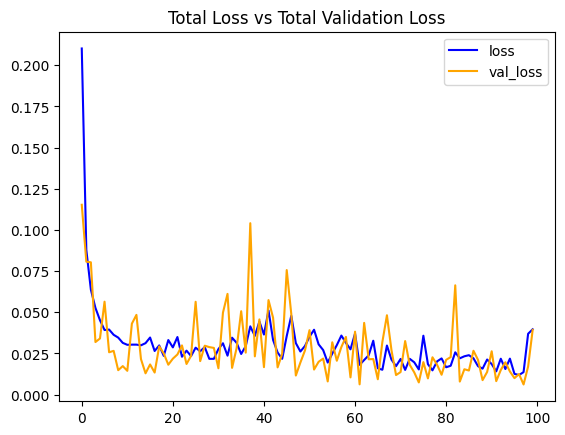

In [37]:
plot_metric(history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

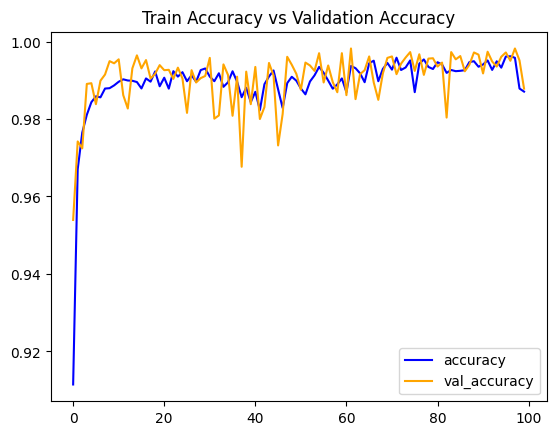

In [38]:
plot_metric(history, 'accuracy', 'val_accuracy', 'Train Accuracy vs Validation Accuracy')

In [39]:
model.save_weights('poseLSTM.weights.h5')

In [40]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 98.59%
